# Investigating device properties with GEM experiment


### 1. Overview
GEM (Generation of Entanglement by Measurement) is a measurement-based technique to prepare device-wide entangled states using constant-depth circuits. While based on long-standing ideas from measurement-based computation, the technique was recently experimentally studied in detail by [Edward H. Chen et. al](https://arxiv.org/abs/2309.02863). This repository allows a user to implement the entanglement preparation protocol on a heavy-hexagonal lattice of qubits on IBM processors, and provides a concrete way to study the protocol's robustness to noise on account of the two-dimensional topology. The code is built on [Qiskit Experiments](https://github.com/Qiskit-Extensions/qiskit-experiments), a general framework for designing and organizing complex quantum experiments at scale.

In [1]:
from gem_suite import PlaquetteLattice
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

### 2. Plaquette Concept

Key to understanding the GEM protocol is the concept of a basic, repeatable, experimental unit called a "plaquette." This object is tiled across the quantum processor, and is composed of a single heavy-hexagonal lattice. The single experimental unit forms a collection of 12 qubits. Because of this, 125 of the available 127 qubits on an IBM Eagle device can be represented by 18 plaquettes. Their connectivity can be also visualized by a graph, where each edge on the plaquette graph shares 3 physical qubits.

In [2]:
plaquettes = PlaquetteLattice.from_backend(FakeSherbrooke())

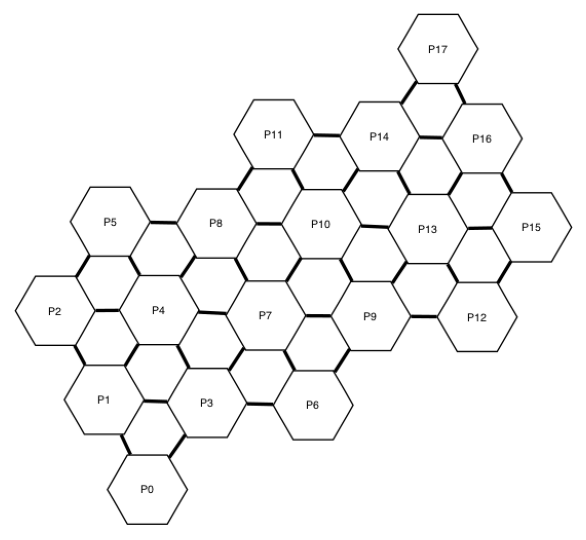

In [3]:
plaquettes.draw_plaquettes()

We can get component qubits in each plaquette by calling the `.plaquettes` method.

In [4]:
next(plaquettes.plaquettes())

PyPlaquette(index=0, qubits=[0, 1, 2, 3, 4, 14, 15, 18, 19, 20, 21, 22], neighbors=[3, 1])

### High Level Overview of the GEM Protocol

Shown below in this graph view with convenient annotations, qubits can be classified as either site or bond qubits. The filled gray circles are site qubits while the open circles are bond qubits. To turn an initial product state of site qubits in +1 X eigenstates into a GHZ-type state, we measure the ZZ parities on all nearest neighbor site qubits using the bond qubits in between. We sweep the control rotation angle to the "A" sublattice (site qubits with annotation "A"). This induces a coupling to bond qubits beyond a simple Clifford CNOT gate. By varying this angle away from the Clifford limit we can successfully perform tunable weak measurements.

Three layers of entangling operations are always needed in the heavy hexagonal lattice due to the degree-3 connectivity. Edges in the graph are also grouped by different colors. Graph edges are scheduled so that no adjacent edges appear in the same layer, avoiding collisions. In this configuration, we can generate 12 different scheduling patterns which may yield different noise levels due to different contributions of gate crosstalk.

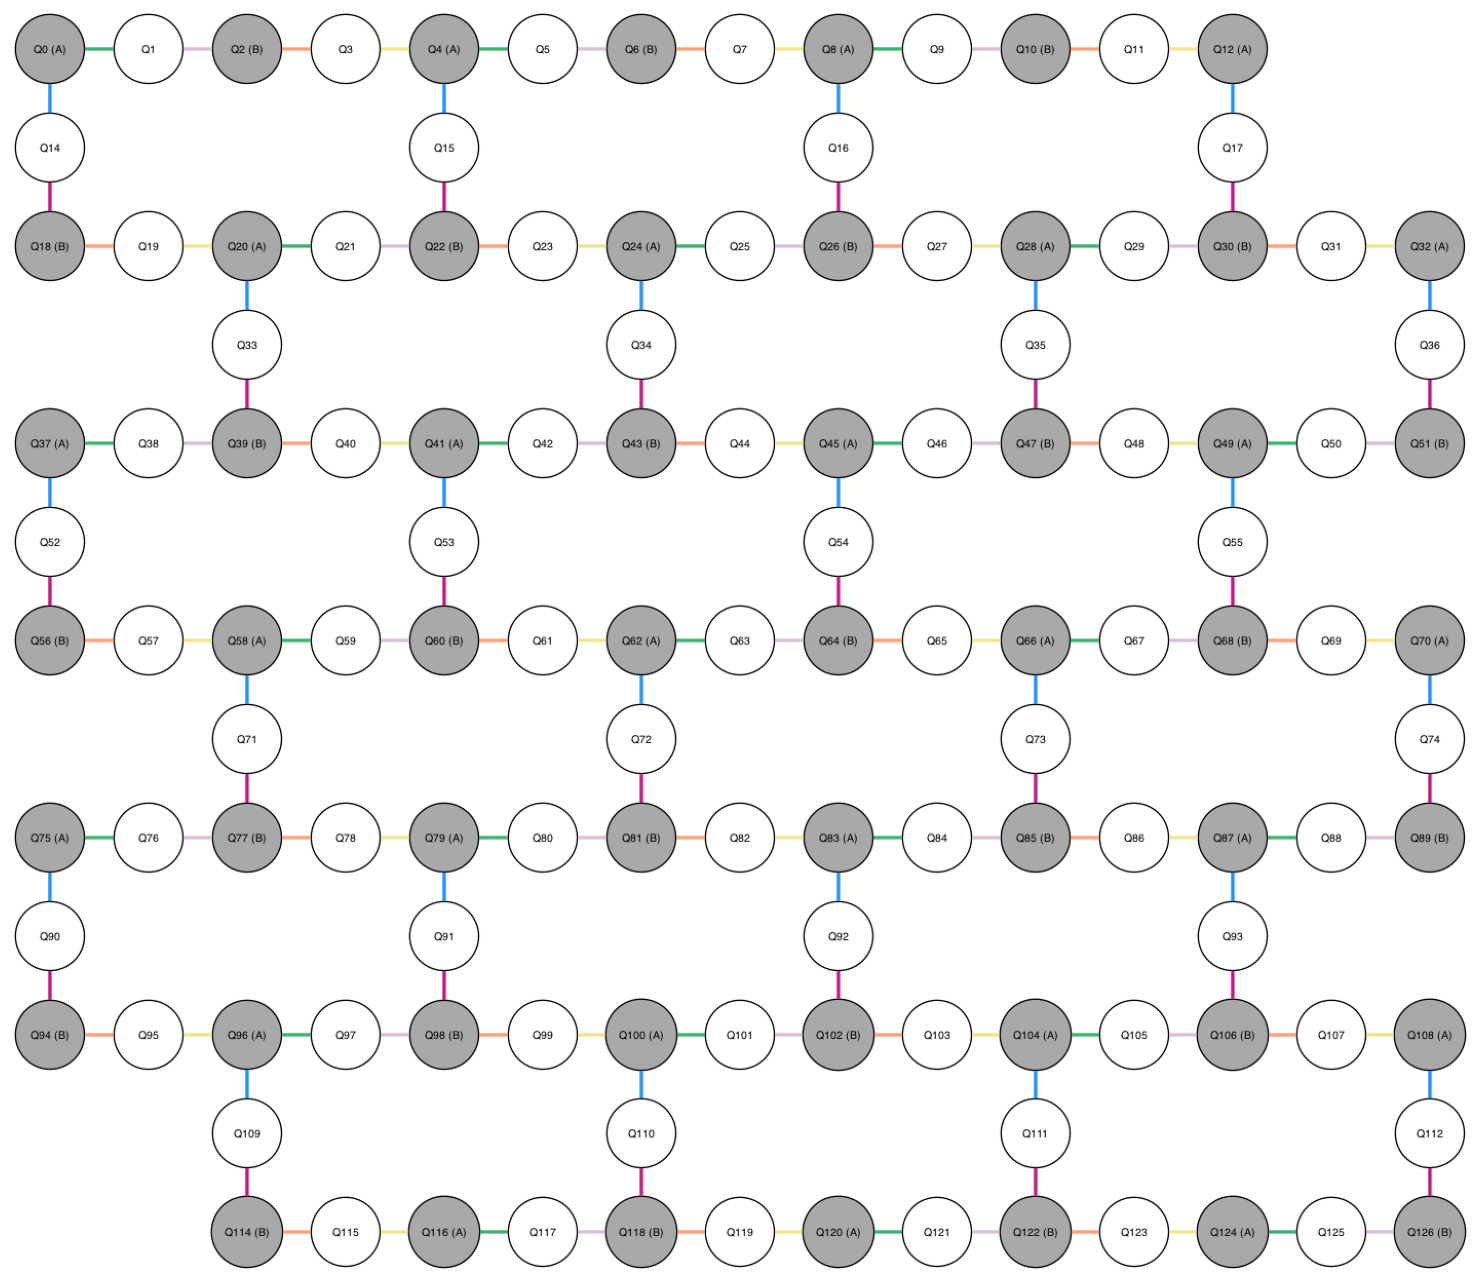

In [5]:
plaquettes.draw_qubits()

The `PlaquetteLattice` offers a method to generate the gate schedules by consuming the annotated qubit graph above. Using these gate schedules, GEM circuits of all scales and types can be prepared.

In [6]:
for i, group in enumerate(plaquettes.build_gate_schedule(10)):
    print(f"group #{i}")
    for j, edge in enumerate(group):
        if j > 5:
            print("...")
            break
        print(edge)

group #0
PyGate(index0=3, index1=4, group="A")
PyGate(index0=7, index1=8, group="A")
PyGate(index0=11, index1=12, group="A")
PyGate(index0=19, index1=20, group="A")
PyGate(index0=23, index1=24, group="A")
PyGate(index0=27, index1=28, group="A")
...
group #1
PyGate(index0=0, index1=1, group="A")
PyGate(index0=4, index1=5, group="A")
PyGate(index0=8, index1=9, group="A")
PyGate(index0=20, index1=21, group="A")
PyGate(index0=24, index1=25, group="A")
PyGate(index0=28, index1=29, group="A")
...
group #2
PyGate(index0=0, index1=14, group="A")
PyGate(index0=4, index1=15, group="A")
PyGate(index0=8, index1=16, group="A")
PyGate(index0=12, index1=17, group="A")
PyGate(index0=20, index1=33, group="A")
PyGate(index0=24, index1=34, group="A")
...


We can also build a sublattice from our plaquette lattice, if there is a particular subset of interest (e.g. `P0`, `P1`, `P2` and `P3` below).

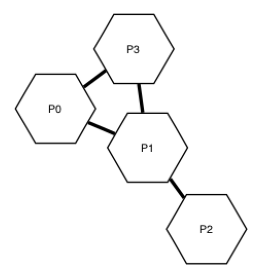

In [7]:
sub_plaquettes = plaquettes.filter([0, 1, 2, 3])
sub_plaquettes.draw_plaquettes()

### 2. Running through Qiskit Experiments

Now let's move on to integration into Qiskit Experiments. Although in principle we can build and run the GEM experiment manually, it's convenient to run it through the Qiskit Experiments class.

In [8]:
from gem_suite.experiments import GemExperiment
from qiskit_ibm_runtime.fake_provider import FakeGeneva

In [9]:
gem_exp = GemExperiment([0, 1], backend=FakeGeneva())

The experiment class can be instantiated either with numerical indices of plaquettes or a `PlaquetteLattice` instance. In this example, we use FakeGeneva backend with 27 qubits so that the experiment can run on the Qiskit Aer simulator. `pip install qiskit-aer` is required to continue.

In [10]:
gem_exp.experiment_options

Options(max_circuits=None, schedule_idx=None, sweep_type='A', min_angle=0, max_angle=1.5707963267948966, num_angles=21, angles=None)

In [11]:
gem_exp.set_experiment_options(schedule_idx=10)

We only simulate a single scheduling pattern since this simulation is expensive. In default setting, the GEM experiment runs 21 experiment circuits with different control rotation angles from [0, pi/2], where pi/2 is at the Clifford limit. Without specifying the `scheduling_idx`, the experiment tries all 12 scheduling patterns and computes the result as an average of these patterns. In total, 252 circuits will run in a single execution. Here we run only scheduling index 10.

With a real backend, we can simply run the following code to get the results.

In [12]:
# exp_data = gem_exp.run().block_for_results()

In case of the density matrix simulator, noisy ISA circuits with 27 qubits are hardly able to be executed on a standard laptop computer. Instead, we cleverly bypass transpilation and consideration of ancilla qubits in the full layout. We will see the complete workflow with a real utility scale computer later.

Without transpiling, the GEM circuits have only 21 qubits. This circuit can be simulated on a laptop. Here we directly run a virtual (non-transpiled) circuit on the Aer simulator with a noise model. In contrast to RB-variant protocols such as the [layer fidelity experiment](https://arxiv.org/abs/2311.05933) the GEM protocol is sensitive to the measurement error by design. We can recover the noiseless state with the Minimum Weight Perfect Matching (MWPM) decoder. At a critical control angle, this recovery starts to fail. It is at this failure point that the Nishimori transition occurs.

In this simulation, we only consider the impact of measurement errors.

In [13]:
from qiskit_experiments.framework import ExperimentData
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError

import numpy as np

In [14]:
rng = np.random.default_rng(1234)

noise_model = NoiseModel()
for vi, _ in enumerate(gem_exp.physical_qubits):
    err = rng.uniform(0.0, 0.05)
    noise_model.add_readout_error(ReadoutError([[1.0 - err, err], [err, 1.0 - err]]), [vi])
sim_backend = AerSimulator(noise_model=noise_model, seed_simulator=5678)

In [15]:
job = sim_backend.run(gem_exp.circuits(), shots=10000)

In [16]:
exp_data = ExperimentData(experiment=gem_exp, backend=sim_backend)
exp_data.add_jobs(job)
exp_data.block_for_results()

ExperimentData(GemExperiment, 376ddb4f-77b4-41ef-94df-e1c9925823c3, job_ids=['1379b431-8f2e-4d7e-879b-287c95696bec'], metadata=<5 items>)

In [17]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 336 ms, sys: 27.4 ms, total: 364 ms
Wall time: 404 ms


After the experiment completes, we can get four quantities in the analysis results dataframe. Each parameter characterizes the capability of entanglement preparation of this quantum processor from different aspect.

#### max_tpc
An average of the maximum two-point (classical) correlation between two arbitrary site qubits. The higher the value, the better the entanglement generation capability (range [0.0, 1.0]).

#### critical_angle
A control rotation angle where the Nishimori transition occurs. 0.5 is the Clifford limit and thus the maximum value of the quantity. The smaller the value, the better the noise tolerance (range [0.0, 0.5]).

#### p_bond_mean
A parameter characterizing the average measurement error in bond qubits and noise during the entangling process.

#### p_site_mean
A parameter characterizing the average measurement error in site qubits.

In [18]:
analyzed_data.analysis_results(dataframe=True)

,name,experiment,components,value,quality,backend,run_time,chisq,aic
6c9844ab,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.7846+/-0.0031,None,aer_simulator,None,None,None
22c6a4a4,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.325,None,aer_simulator,None,None,None
d5f8d649,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0269+/-0.0014,Good,aer_simulator,None,1.672652,12.700862
6075c3ea,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0241+/-0.0030,Good,aer_simulator,None,1.672652,12.700862


In addition to above numbers, you will find four figures associated with the result.

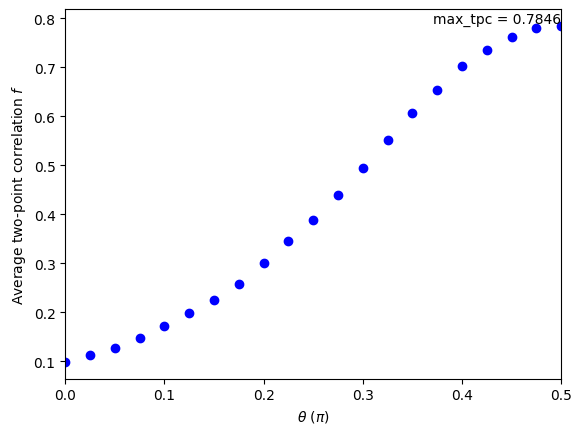

In [19]:
analyzed_data.figure(0)

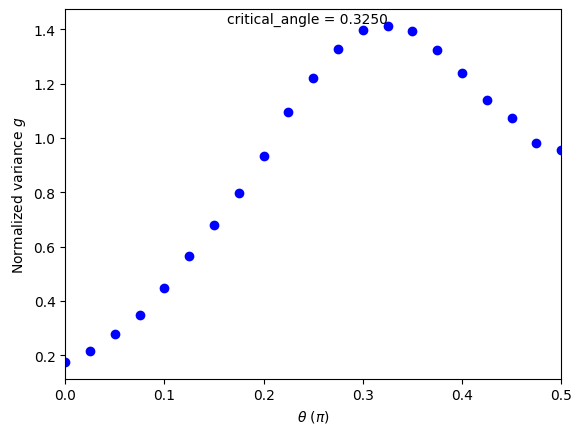

In [20]:
analyzed_data.figure(1)

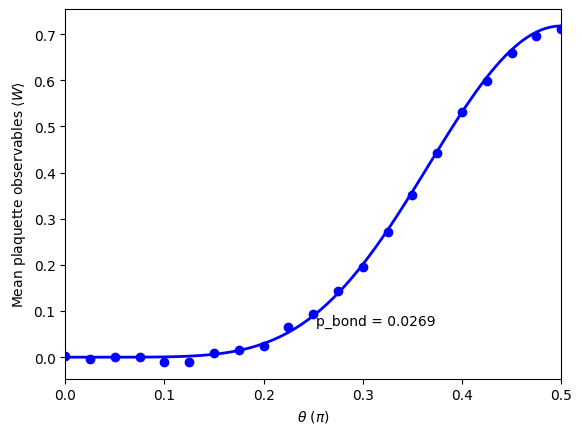

In [21]:
analyzed_data.figure(2)

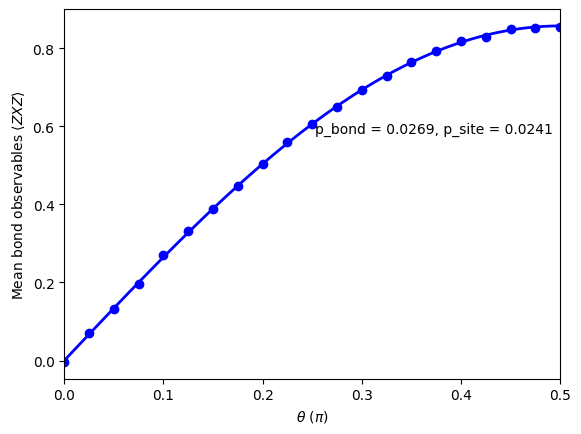

In [22]:
analyzed_data.figure(3)

### 3. Customizing measurement options
You can also customize analysis options.

In [23]:
gem_exp.analysis.options

Options(figure_names=None, analyze_individual_bond=False, analyze_clifford_limit=False, decoder='pymatching')

First, our library implements two MWPM decoders, namely [pymatching](https://github.com/oscarhiggott/PyMatching) and [fusion-blossom](https://github.com/yuewuo/fusion-blossom). The quality of the result doesn't significantly depend on the choice of decoder and they are tested against the same mock configuration to confirm the results are comparable. Unfortunately the latter is slower (although its implemented in Rust and in principle there is no FFI overhead with our library, which is also written in Rust). Thus, our setting defaults to the pymatching decoder.

Note that in the default configuration we only see the wholistic metrics of the entire processor. We can also produce local properties in different levels. With small addition of computing resources, you can obtain a quality metric for each plaquette.

In [24]:
gem_exp.analysis.set_options(analyze_clifford_limit=True, analyze_individual_bond=False, decoder="pymatching")

In [25]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 379 ms, sys: 72.3 ms, total: 452 ms
Wall time: 692 ms


In [26]:
res = analyzed_data.analysis_results(dataframe=True); res

,name,experiment,components,value,quality,backend,run_time,chisq,aic,plaquette
3bb410b0,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.7846+/-0.0031,None,aer_simulator,None,None,None,None
a00eea46,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.325,None,aer_simulator,None,None,None,None
e94d96e0,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0269+/-0.0014,Good,aer_simulator,None,1.672652,12.700862,None
f886d74a,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0241+/-0.0030,Good,aer_simulator,None,1.672652,12.700862,None
a05db272,plaquette_quality,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.8405959051832326+/-0,None,aer_simulator,None,None,None,0
6089a6c3,plaquette_quality,GemExperiment,"[Q12, Q13, Q14, Q15, Q16, Q18, Q19, Q21, Q22, ...",0.8246114147824619+/-0,None,aer_simulator,None,None,None,1


The quality metric is computed as a geometric means of $\langle W \rangle$ observable and all $\langle ZXZ \rangle$ observables in the plaquette at the Clifford limit, where the $\langle W \rangle = \langle ZZZZZZ \rangle$ is the plaquette observable of six bond qubits in the plaquette, and $\langle ZXZ \rangle$ is a bond correlations in the plaquette. You must include pi/2 in your experiment parameter to obtain these numbers. Without noise, this metric becomes 1.0 and it is somewhat related to the regional quality of your quantum processor. This may help you with extracting the best part of your processor to run circuits with a common pandas dataframe operation like below.

In [27]:
best_plaquette = res[res.name == "plaquette_quality"].sort_values("value", ascending=False).iloc[0]
best_qubits = [q.index for q in best_plaquette.components]
best_qubits

[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14]

This option will produce an extra figure to visualize the distribution of metric across different plaquettes regions. The brightness of the filled plaquettes is proportional to the value of the metric.

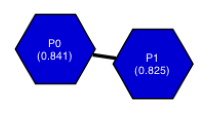

In [28]:
analyzed_data.figure(4)

In principle, we can compute p_bond and p_site parameters for each bond. This will produce more localized view of the device quality.

In [29]:
gem_exp.analysis.set_options(analyze_clifford_limit=False, analyze_individual_bond=True, decoder="pymatching")

In [30]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 737 ms, sys: 129 ms, total: 866 ms
Wall time: 464 ms


In [31]:
res = analyzed_data.analysis_results(dataframe=True); res

,name,experiment,components,value,quality,backend,run_time,chisq,aic
72d5a634,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.7846+/-0.0031,None,aer_simulator,None,None,None
d25aea45,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.325,None,aer_simulator,None,None,None
08524307,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0269+/-0.0014,Good,aer_simulator,None,1.672652,12.700862
5a8ba19c,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0241+/-0.0030,Good,aer_simulator,None,1.672652,12.700862
742b12ba,p_bond,GemExperiment,"[Q2, Q3, Q1]",0.5+/-nan,Good,aer_simulator,None,0.0,None
7cdf6334,p_site,GemExperiment,"[Q2, Q3, Q1]",0.45588349978499815+/-nan,Good,aer_simulator,None,0.0,None
98ca4302,p_bond,GemExperiment,"[Q4, Q7, Q1]",0.5+/-nan,Good,aer_simulator,None,0.0,None
bb8dff24,p_site,GemExperiment,"[Q4, Q7, Q1]",0.44563060056604287+/-nan,Good,aer_simulator,None,0.0,None
8a6c75e8,p_bond,GemExperiment,"[Q5, Q8, Q3]",0.5+/-nan,Good,aer_simulator,None,0.0,None
f9abc5a5,p_site,GemExperiment,"[Q5, Q8, Q3]",0.44705361252827314+/-nan,Good,aer_simulator,None,0.0,None


### 4. Utility-scale experiments with a real quantum processor

Lastly we demonstrate how to run the GEM experiment on a real quantum processor from IBM Quantum. The workflow is much simpler because there is no resource limit in the classical computation to run the experiment. We just run it and wait for the result. In this example we test all 12 scheduling patterns to see the dependency on the gate crosstalk. The more divergent the traces (i.e. gray lines behind blue scatters), the greater the contribution of the gate crosstalk.

With one of the Eagle processors like ibm_cusco, we can run the GEM experiment using 18 plaquettes.

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [33]:
backend = QiskitRuntimeService().backend("ibm_cusco")

In [34]:
gem_exp = GemExperiment(range(18), backend=backend)
gem_exp.analysis.set_options(analyze_clifford_limit=True, analyze_individual_bond=False, decoder="pymatching")
exp_data = gem_exp.run(analysis=None).block_for_results()

In [35]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 9.88 s, sys: 217 ms, total: 10.1 s
Wall time: 10.5 s


In [36]:
analyzed_data.analysis_results(dataframe=True)

,name,experiment,components,value,quality,backend,run_time,chisq,aic,plaquette
b005dfde,max_tpc,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.05429+/-0.00032,None,ibm_cusco,None,None,None,None
218ba067,critical_angle,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.5,None,ibm_cusco,None,None,None,None
2bd51253,p_bond_mean,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.270+/-0.013,Good,ibm_cusco,None,0.381915,-18.315467,None
6da8553b,p_site_mean,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.110+/-0.016,Good,ibm_cusco,None,0.381915,-18.315467,None
87b635e4,plaquette_quality,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q14, Q15, Q18, Q19, Q20, ...",0.35+/-0.06,None,ibm_cusco,None,None,None,0
61c5fd25,plaquette_quality,GemExperiment,"[Q4, Q5, Q6, Q7, Q8, Q15, Q16, Q22, Q23, Q24, ...",0.308+/-0.016,None,ibm_cusco,None,None,None,1
95739237,plaquette_quality,GemExperiment,"[Q8, Q9, Q10, Q11, Q12, Q16, Q17, Q26, Q27, Q2...",0.25+/-0.04,None,ibm_cusco,None,None,None,2
288fad95,plaquette_quality,GemExperiment,"[Q20, Q21, Q22, Q23, Q24, Q33, Q34, Q39, Q40, ...",0.369+/-0.029,None,ibm_cusco,None,None,None,3
55e61abb,plaquette_quality,GemExperiment,"[Q24, Q25, Q26, Q27, Q28, Q34, Q35, Q43, Q44, ...",None,None,ibm_cusco,None,None,None,4
6833a0bf,plaquette_quality,GemExperiment,"[Q28, Q29, Q30, Q31, Q32, Q35, Q36, Q47, Q48, ...",0.18+/-0.04,None,ibm_cusco,None,None,None,5


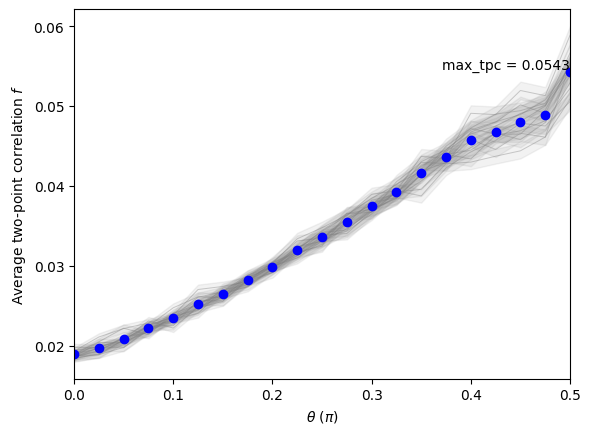

In [37]:
analyzed_data.figure(0)

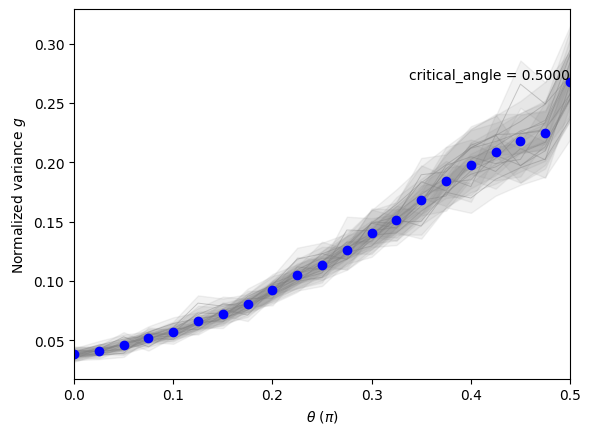

In [38]:
analyzed_data.figure(1)

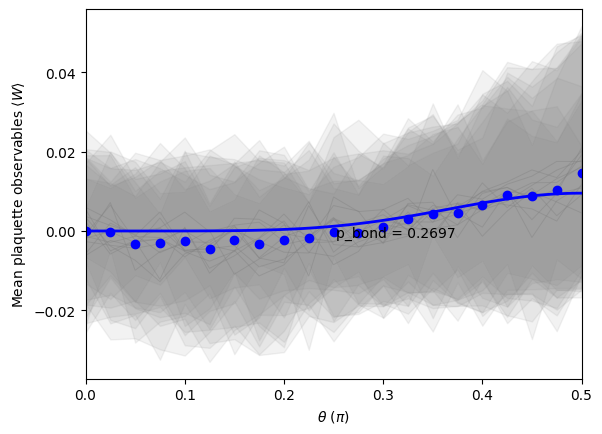

In [39]:
analyzed_data.figure(2)

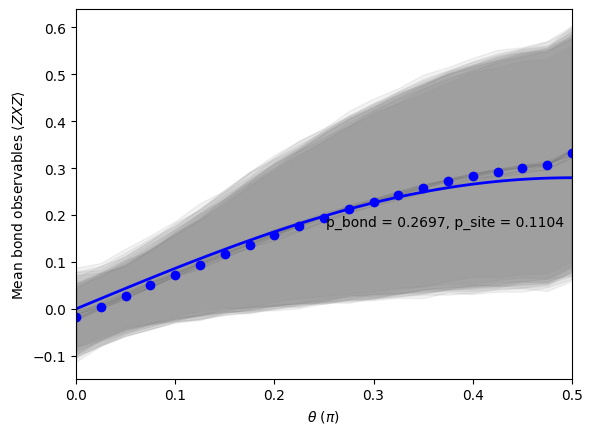

In [40]:
analyzed_data.figure(3)

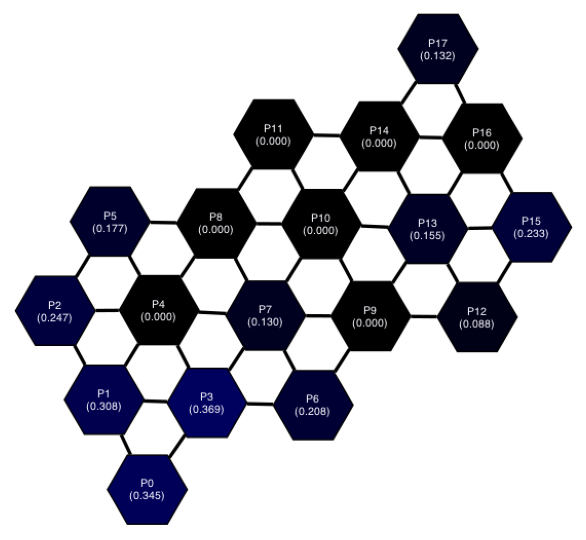

In [41]:
analyzed_data.figure(4)

As you can see, $\langle W \rangle$ or $\langle ZXZ \rangle$ observables show negative value in several plaquettes, even in the Clifford limit. This indicates that the decoder output doesn't produce the long range order owing to non-negligible imperfection in the real quantum hardware. This is also explained by the small `max_tpc` metric compared with the previous simulation. However, there is still a well-behaving region aound the plaquette `P0`. Since these metrics strongly depend on measurement noise, you may see a trend different from the EPLGs (error per layered gates) and conventional EPGs (error per gates).

### 5. Investigate hardware error

The GEM experiment tells us not only the wholistic performance of entanglement generation, but also local trends of hardware imperfection. On one hand, $f$ and $g$ are computed from the decoded bitstrings. On the other hand, $\langle W \rangle$ and $\langle ZXZ \rangle$ observables are computed from raw readout of bond and neighboring site qubits. In this analysis, we focus on the latter properties. Altough above plots show the average of all observables as a wholistic metric, we can manually run the plaquette analysis to resolve local errors.

As an example, we will take the result at the Clifford limit ($\theta = \pi/2$) with the scheduling pattern 0.

In [83]:
data = exp_data.data(20)
data["metadata"]

{'schedule_index': 0, 'theta': 0.5}

A `GemExperiment` instance internally stores the `PlaquetteLattice` instance as a core of this experiment. This object governs data processing in every step from the experiment circuit generation to analysis, which is immediately configured by digesting the device coupling map, when you instantiate the experiment. The `GemExpeirment` and the associated analysis are just convenient Python wrapper class of it to align with the common Qiskit Experiments workflow.

By directly calling the plaquette decoder, we can get local observables from a particular experiment data before they get averaged. We first check the $W$ observables. Recall that this observable is computed from the readout of six bond qubits in a plaquette, which ideally becomes 1.0 (even parity) at the Clifford limit to form the GHZ state.

In [84]:
outcomes = gem_exp.plaquettes.decode_outcomes(data["counts"])
bond_qubits = sorted([q for q in gem_exp.plaquettes.qubits() if q.role == "Bond"], key=lambda q: q.index)

In [85]:
for pi, w_op in enumerate(outcomes.w_ops):
    print(f"Plaquette {pi:2d}: W = {w_op:.3f}")

Plaquette  0: W = 0.056
Plaquette  1: W = 0.066
Plaquette  2: W = 0.046
Plaquette  3: W = 0.084
Plaquette  4: W = -0.002
Plaquette  5: W = 0.018
Plaquette  6: W = 0.053
Plaquette  7: W = 0.004
Plaquette  8: W = 0.013
Plaquette  9: W = 0.012
Plaquette 10: W = 0.006
Plaquette 11: W = -0.018
Plaquette 12: W = 0.003
Plaquette 13: W = -0.018
Plaquette 14: W = 0.009
Plaquette 15: W = 0.033
Plaquette 16: W = 0.009
Plaquette 17: W = -0.012


Obviously some plaquettes show significantly poor expectation values for $W$, though states are far apart from good entanglement overall. Here we investigate the plaquette 0 and 4 as a good and bad example, respectively. We can get a list of component qubits from the `PyPlaquette` object. By using this qubit list, we can extract all $ZXZ$ observables associated with certain plaquette.

In [86]:
P4 = list(gem_exp.plaquettes.plaquettes())[4]; P4

PyPlaquette(index=4, qubits=[24, 25, 26, 27, 28, 34, 35, 43, 44, 45, 46, 47], neighbors=[8, 7, 5, 3, 2, 1])

In [87]:
for qubit, zxz in zip(bond_qubits, outcomes.zxz_ops):
    if qubit.index not in P4.qubits:
        continue
    print(f"Bond Q{qubit.index:3d}: ZXZ = {zxz:.3f}")

Bond Q 25: ZXZ = 0.404
Bond Q 27: ZXZ = 0.488
Bond Q 34: ZXZ = 0.533
Bond Q 35: ZXZ = 0.208
Bond Q 44: ZXZ = 0.456
Bond Q 46: ZXZ = -0.059


In the plaquette 4, you can find significantlly bad bond qubits that likely created poor entanglement during the experiment. For example, the Q46 shows a negative expectation value for $ZXZ$, which indicates this bond qubit doesn't generate entanglement between two neighboring site qubits. Note that this analysis doesn't give you any insight into physical mechanisms of the error, and you need to perform conventional benchmark experiments to identify the root cause. However, you can still consider avoiding this qubits or trigger calibration around this region when you run application circuits.

In [88]:
bond_qubits[25]

PyQubit(index=46, role="Bond", group="None", coordinate=(9, 4), neighbors=[47, 45])

Finally we can also investigate the plaquette 0 in the same way. In contrast to the previous one, this plaquette shows relatively better $ZXZ$ expectation values overall.

In [89]:
P0 = list(gem_exp.plaquettes.plaquettes())[0]; P0

PyPlaquette(index=0, qubits=[0, 1, 2, 3, 4, 14, 15, 18, 19, 20, 21, 22], neighbors=[3, 1])

In [90]:
for qubit, zxz in zip(bond_qubits, outcomes.zxz_ops):
    if qubit.index not in P0.qubits:
        continue
    print(f"Bond Q{qubit.index:3d}: ZXZ = {zxz:.3f}")

Bond Q  1: ZXZ = 0.467
Bond Q  3: ZXZ = 0.341
Bond Q 14: ZXZ = 0.738
Bond Q 15: ZXZ = 0.539
Bond Q 19: ZXZ = 0.561
Bond Q 21: ZXZ = 0.591
